<a href="https://colab.research.google.com/github/Lisarika-kanchumarthi/Time_Series_Modelling/blob/main/Time_Series_Modelling_jj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup & Library Imports**

In [1]:
# Installing and import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import boxcox
from scipy.fft import fft
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]


**Mounted Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Loading and Plotting the Data**

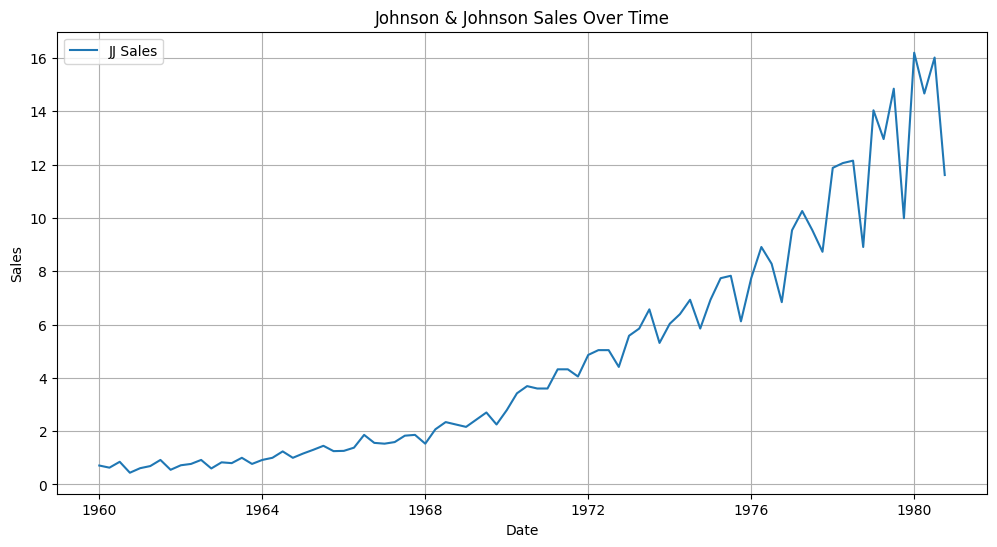

In [4]:
# Loading the Johnson & Johnson dataset
df = pd.read_csv('/content/drive/My Drive/TimeSeriesAssignment/jj.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Plotting original data
plt.plot(df['data'], label='JJ Sales')
plt.title("Johnson & Johnson Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


**Augmented Dickey-Fuller (ADF) test and rolling statistics**

ADF Test Result
ADF Statistic: 2.7420165734574744
p-value: 1.0
Critical Value (1%): -3.524624466842421
Critical Value (5%): -2.9026070739026064
Critical Value (10%): -2.5886785262345677


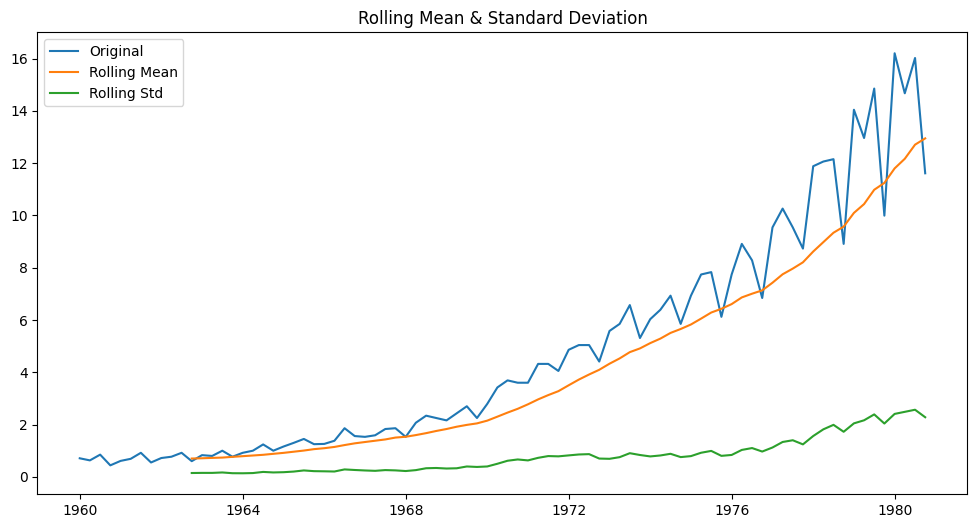

In [10]:
# ADF Test
result = adfuller(df['data'])
print("ADF Test Result")
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

# Plotting Rolling Mean and Std
rolmean = df['data'].rolling(window=12).mean()
rolstd = df['data'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(df['data'], label='Original')
plt.plot(rolmean, label='Rolling Mean')
plt.plot(rolstd, label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()


**First-order Differencing**

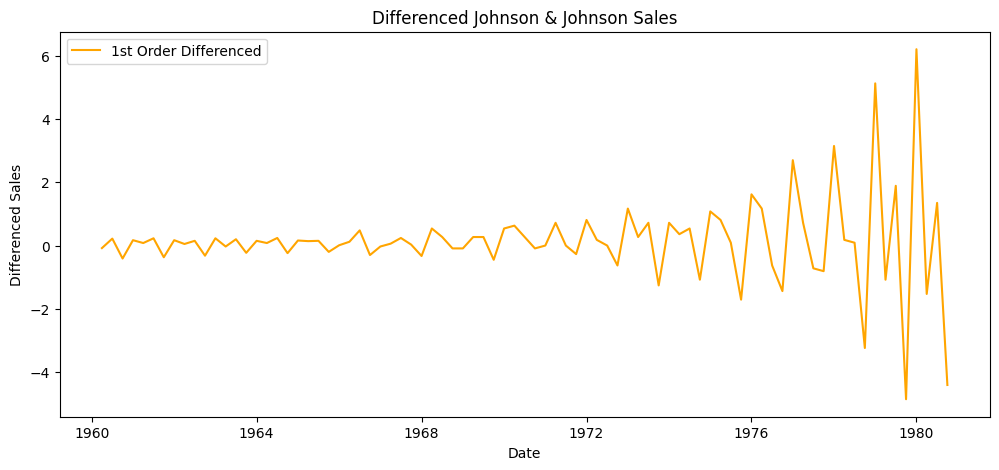

ADF Statistic (1st Differenced): -0.40740976363804615
p-value (1st Differenced): 0.9088542416911305
Critical Value (1%): -3.524624466842421
Critical Value (5%): -2.9026070739026064
Critical Value (10%): -2.5886785262345677


In [11]:
# First Differencing
df_diff1 = df['data'].diff().dropna()

# Plotting differenced data
plt.figure(figsize=(12, 5))
plt.plot(df_diff1, color='orange', label='1st Order Differenced')
plt.title("Differenced Johnson & Johnson Sales")
plt.xlabel("Date")
plt.ylabel("Differenced Sales")
plt.legend()
plt.show()

# ADF Test after differencing
result_diff1 = adfuller(df_diff1)
print("ADF Statistic (1st Differenced):", result_diff1[0])
print("p-value (1st Differenced):", result_diff1[1])
for key, value in result_diff1[4].items():
    print(f"Critical Value ({key}): {value}")


**Second-order Differencing**

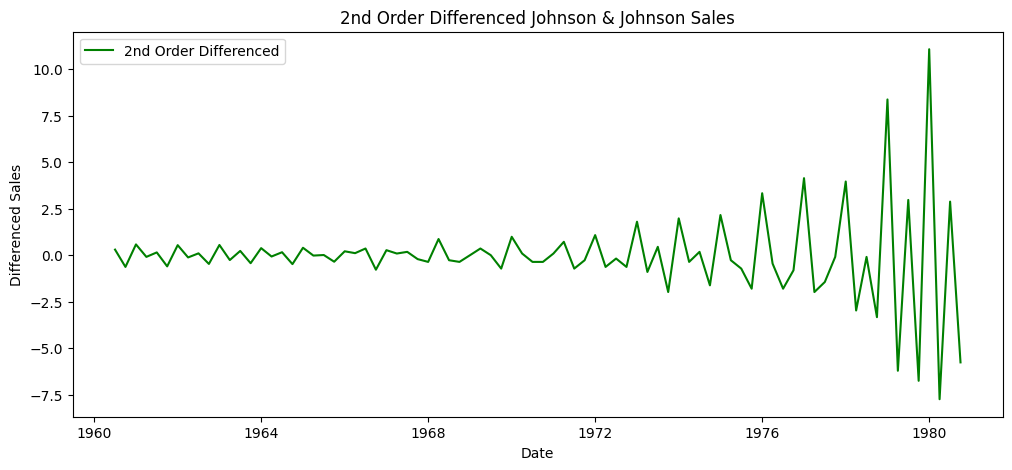

ADF Statistic (2nd Differenced): -3.585162874793155
p-value (2nd Differenced): 0.006051099869603682
Critical Value (1%): -3.524624466842421
Critical Value (5%): -2.9026070739026064
Critical Value (10%): -2.5886785262345677


In [12]:
# Second differencing
df_diff2 = df['data'].diff().diff().dropna()

# Plotting the second differenced series
plt.figure(figsize=(12, 5))
plt.plot(df_diff2, color='green', label='2nd Order Differenced')
plt.title("2nd Order Differenced Johnson & Johnson Sales")
plt.xlabel("Date")
plt.ylabel("Differenced Sales")
plt.legend()
plt.show()

# ADF test after second differencing
result_diff2 = adfuller(df_diff2)
print("ADF Statistic (2nd Differenced):", result_diff2[0])
print("p-value (2nd Differenced):", result_diff2[1])
for key, value in result_diff2[4].items():
    print(f"Critical Value ({key}): {value}")


**Model Selection using ACF and PACF Plots – Identifying ARIMA(p, d, q) Parameters**

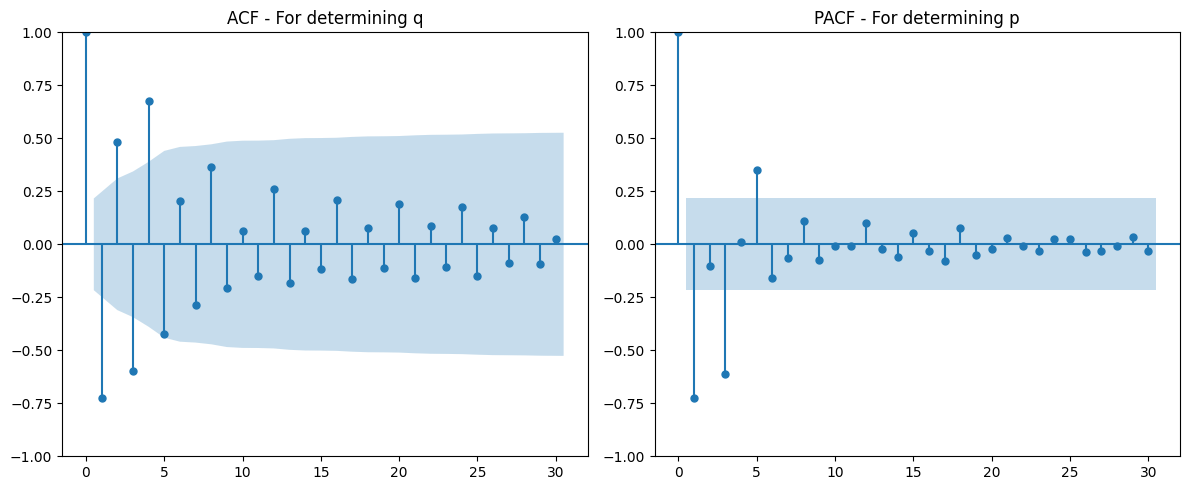

In [8]:
# ACF and PACF plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(df_diff2, lags=30, ax=plt.gca())
plt.title("ACF - For determining q")

plt.subplot(1, 2, 2)
plot_pacf(df_diff2, lags=30, ax=plt.gca())
plt.title("PACF - For determining p")

plt.tight_layout()
plt.show()


**Chosen Model: ARIMA(2, 2, 1)**

In [9]:
# fitting ARIMA(2,2,1) model
model_221 = ARIMA(df['data'], order=(2, 2, 1))
model_221_fit = model_221.fit()

# Print summary
print(model_221_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -130.055
Date:                Fri, 11 Apr 2025   AIC                            268.110
Time:                        09:25:50   BIC                            277.737
Sample:                             0   HQIC                           271.975
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7225      0.080     -9.042      0.000      -0.879      -0.566
ar.L2         -0.1752      0.108     -1.619      0.105      -0.387       0.037
ma.L1         -0.9743      0.032    -30.500      0.0

 **Forecasting 24 Months Into the Future**

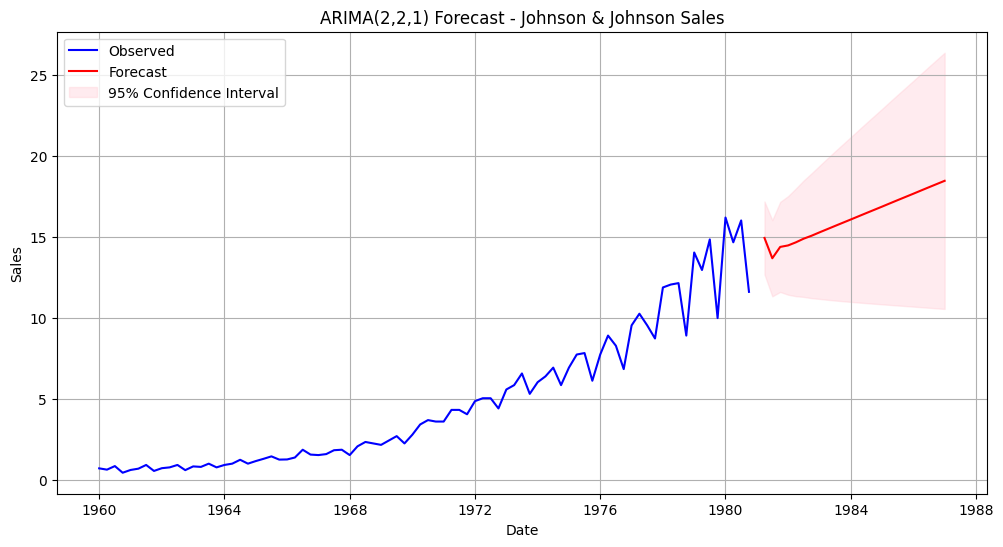

In [14]:
# Forecasting 24 future months
forecast_obj = model_221_fit.get_forecast(steps=24)
forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

# To Create future quarterly index
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date, periods=25, freq='Q')[1:]

# Plotting forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(df['data'], label='Observed', color='blue')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title("ARIMA(2,2,1) Forecast - Johnson & Johnson Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()


**Fourier Analysis**

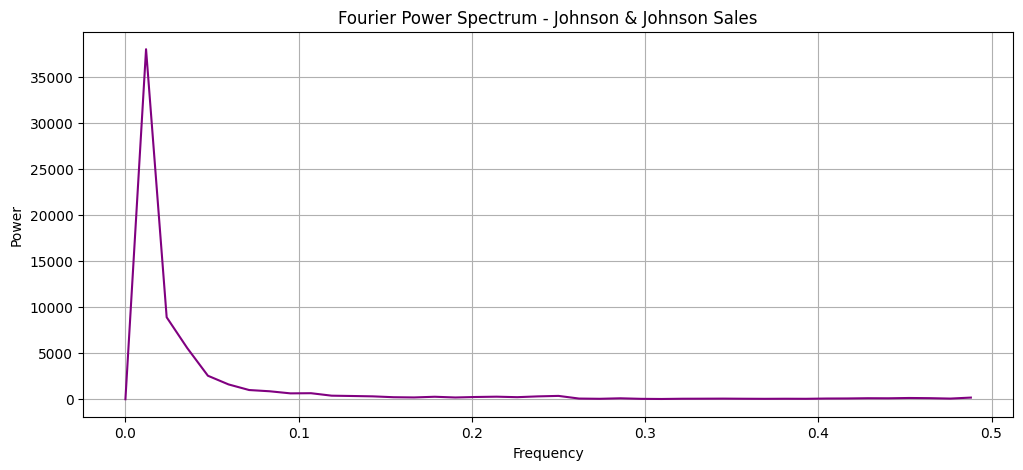

In [15]:
# To detrend the series by subtracting the mean
jj_detrended = df['data'] - df['data'].mean()

# Applying FFT
fft_result = fft(jj_detrended)
n = len(jj_detrended)
freq = np.fft.fftfreq(n)

# To compute Power Spectrum (Magnitude)
power = np.abs(fft_result)**2

# Only to keep the positive frequencies
half_n = n // 2
freq = freq[:half_n]
power = power[:half_n]

# Plotting the power spectrum
plt.figure(figsize=(12, 5))
plt.plot(freq, power, color='purple')
plt.title("Fourier Power Spectrum - Johnson & Johnson Sales")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.grid(True)
plt.show()


**Installing Tensorflow**

In [16]:
!pip install tensorflow


**LSTM Forecasting**

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0453
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0210
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0076
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0054 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0026
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0020
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0012 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0013    
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011    
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0010     
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0011
Epoch 16/50
4/4 ━━━

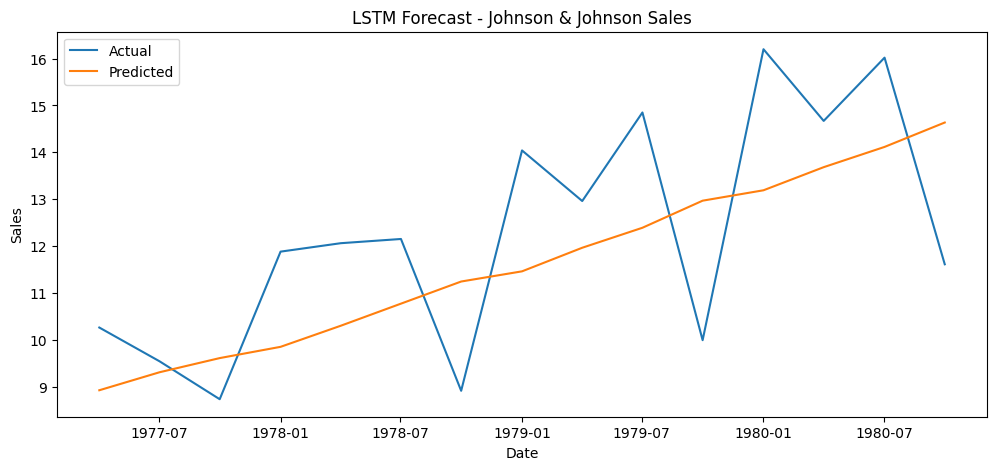

In [17]:
#Importing required libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# Loading the Johnson & Johnson dataset
df_jj = pd.read_csv('/content/drive/My Drive/TimeSeriesAssignment/jj.csv')
df_jj['date'] = pd.to_datetime(df_jj['date'])
df_jj.set_index('date', inplace=True)
data = df_jj['data'].values.reshape(-1, 1)

# To normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# To create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

seq_length = 12
X, y = create_sequences(data_scaled, seq_length)

# Splitting into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# To define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# Predict
predicted = model.predict(X_test)
predicted_rescaled = scaler.inverse_transform(predicted)
y_test_rescaled = scaler.inverse_transform(y_test)

# Ploting the results
plt.figure(figsize=(12, 5))
plt.plot(df_jj.index[-len(y_test):], y_test_rescaled, label='Actual')
plt.plot(df_jj.index[-len(y_test):], predicted_rescaled, label='Predicted')
plt.title('LSTM Forecast - Johnson & Johnson Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


**Evaluation Metrics for LSTM Forecast**

In [18]:
# Extracting actual values for the test period from the original dataset
# Aligning with the index range used in the LSTM test prediction
y_true_jj = df_jj['data'].iloc[train_size + seq_length:].values.flatten()

# Flatten the predicted values (already inverse-transformed to original scale)
y_pred_jj = predicted_rescaled.flatten()

# Calculating evaluation metrics
mse_jj = mean_squared_error(y_true_jj, y_pred_jj)
rmse_jj = np.sqrt(mse_jj)
mae_jj = mean_absolute_error(y_true_jj, y_pred_jj)
mape_jj = np.mean(np.abs((y_true_jj - y_pred_jj) / y_true_jj)) * 100

# Printing results
print("Johnson & Johnson LSTM Forecast Metrics:")
print(f"MSE: {mse_jj:.4f}")
print(f"RMSE: {rmse_jj:.4f}")
print(f"MAE: {mae_jj:.4f}")
print(f"MAPE: {mape_jj:.2f}%")


Johnson & Johnson LSTM Forecast Metrics:
MSE: 4.1725
RMSE: 2.0427
MAE: 1.8601
MAPE: 15.37%
